In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.6 MB/s eta 0:00:00


# **1. Setting up**

In [6]:
# imports
import snntorch as snn
from snntorch import utils

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [8]:
# Training Parameters
batch_size=128
# data_path='/content/drive/MyDrive/Cal\ Poly\ Drive/personal\ projects/data/fashion-mnist_train.csv'
data_path='/tmp/data/fashion-mnist'
num_classes = 10  # fashion MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [10]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

fmnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)

In [13]:
# Only using a small subset of dataset

subset = 10 # 60k -> 6k
fmnist_train = utils.data_subset(fmnist_train, subset)

In [14]:
# Loader serves minibatches of batch_size

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)

In [16]:
print(train_loader)

# **2. Data encoding**

3 encoding options
1. Rate coding: input features -> spiking freq.
2. Latency coding: input features -> spiking time (more noise, less heavy)
3. Delta modulation: temporal change of input features -> spikes (used for when there's a threshold of an event change big *enough* to matter)

In [15]:
from snntorch import spikegen

# num_steps represents the time steps/spiking sequence length
num_steps = 100 # higher num_steps -> spiking prob. closer to raw value

Here we choose rate coding... \\
&nbsp;&nbsp;&nbsp;&nbsp;>Bright pixels have lower spiking prob. \\
&nbsp;&nbsp;&nbsp;&nbsp;>Dark pixels have higher spiking prob.

In [26]:
# Iterate through minibatches
data = iter(train_loader)
input_it, label_it = next(data)

# Encode using rate coding
spike_data = spikegen.rate(input_it, num_steps=num_steps) # default gain=1.0 (spiking freq)

print(spike_data.size())    # structure should be [num_steps, batch_size, input dims]

torch.Size([100, 128, 1, 28, 28])


# **3. Visualization (optional)**

In [27]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [28]:
# Extract a single sample by indexing into the first image of the first batch
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())
spike_data_sample.data

torch.Size([100, 28, 28])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

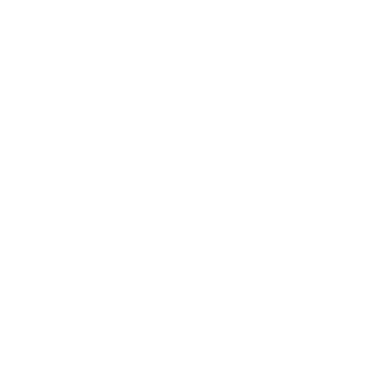

In [29]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
HTML(anim.to_html5_video())

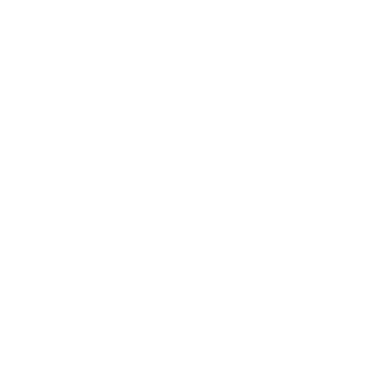

In [33]:
spike_data = spikegen.rate(input_it, num_steps=num_steps, gain=0.75)
spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

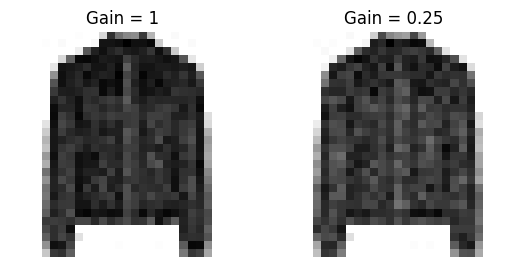

In [34]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show() # higher gain -> clearer reconstruction of image

Next, we implement the model!